In [ ]:
# data analysis library
import numpy as np 
import pandas as pd

# visualization libraries
from pylab import rcParams
import seaborn as sns 
import matplotlib.pyplot as plt 
from wordcloud import WordCloud

import re # regular expression 

# NLP libraries 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from keras.preprocessing.text import Tokenizer 

# model selection 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold

# models 
import keras
import tensorflow as tf
import tensorflow_hub as hub
# import keras.layers import Dense
# from keras.utils import np_utils 
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical 

# metrics 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report


# loading the data
from google.colab import drive
drive.mount('/content/drive')

# plot settings 
plt.rcParams["figure.figsize"] = (14, 6)
plt.style.use('ggplot') 

print("Version: ", tf.__version__) 
print("Hub version: ", hub.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE") 

# for hyper parameter tuning 
!pip install -q -U keras-tuner
import keras_tuner as kt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Version:  2.5.0
Hub version:  0.12.0
Eager mode:  True
GPU is available


In [ ]:
file_path = "/content/drive/MyDrive/DL Assignment 1 - Group-016/tripadvisor_hotel_reviews.csv" 

data = pd.read_csv(file_path) 
print("Size:", data.shape)
data.head()

Size: (20491, 2)


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [ ]:
# checking 2 examples for each rating 
for k, v in data.groupby('Rating'): 
  print("Rating:", k) 
  count = 1
  for i, j in dict(v.Review[0:2]).items(): 
    print(count,".",j) 
    count += 1      

Rating: 1
1 . horrible customer service hotel stay february 3rd 4th 2007my friend picked hotel monaco appealing website online package included champagne late checkout 3 free valet gift spa weekend, friend checked room hours earlier came later, pulled valet young man just stood, asked valet open said, pull bags didn__Ç_é_ offer help, got garment bag suitcase came car key room number says not valet, car park car street pull, left key working asked valet park car gets, went room fine bottle champagne oil lotion gift spa, dressed went came got bed noticed blood drops pillows sheets pillows, disgusted just unbelievable, called desk sent somebody 20 minutes later, swapped sheets left apologizing, sunday morning called desk speak management sheets aggravated rude, apparently no manager kind supervisor weekend wait monday morning, young man spoke said cover food adding person changed sheets said fresh blood rude tone, checkout 3pm package booked, 12 1:30 staff maids tried walk room opening do

Note: The reviews seem to be consistant with the rating awarded.

# Data Visualization

**1. Class (*Rating*) Counts** 


In [ ]:
summary_table_1 = pd.DataFrame(round(data.Rating.value_counts() / len(data) * 100, 2))  
summary_table_1.columns = ['Percentage']
summary_table_1['Rating Counts'] = list(data.Rating.value_counts())   

summary_table_1

,Percentage,Rating Counts
5,44.19,9054
4,29.47,6039
3,10.66,2184
2,8.75,1793
1,6.93,1421


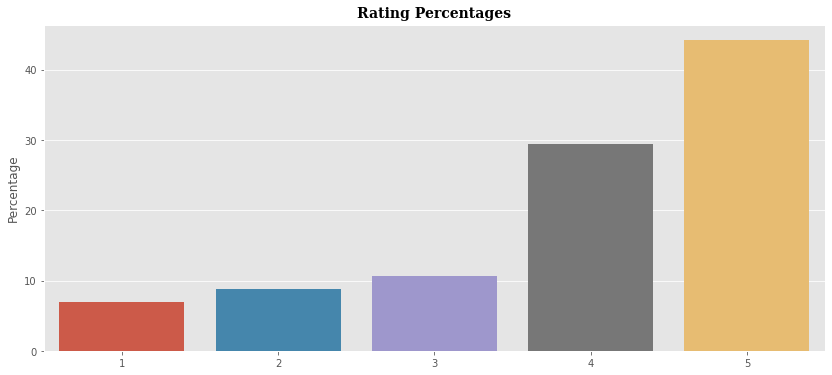

In [304]:
# plotting classes 
sns.barplot(x=summary_table_1.index, y=summary_table_1['Percentage'])
plt.text(2, 48, 'Rating Percentages', fontsize=14, fontweight='bold', 
         horizontalalignment='center', 
         verticalalignment='center',
         fontfamily='serif', color="#000000") 
plt.show() 

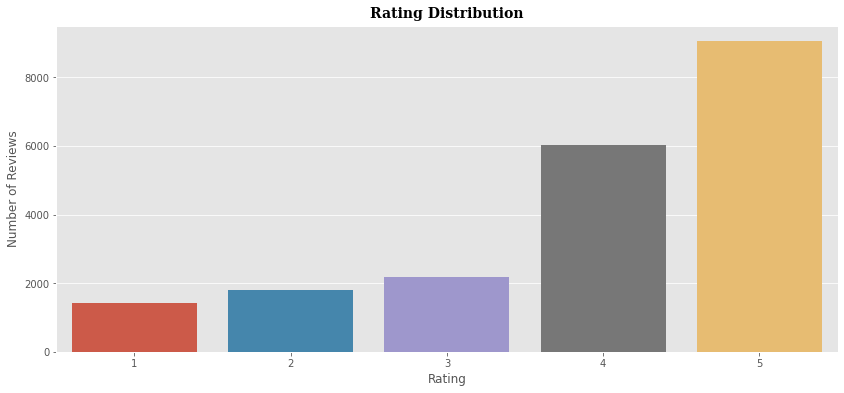

In [299]:
# plotting class counnts 
# plt.figure(figsize=(13, 8))


sns.barplot(x=summary_table_1.index, y=summary_table_1['Rating Counts'])
plt.text(2, 9850, 'Rating Distribution', fontsize=14, fontweight='bold', 
         horizontalalignment='center', 
         verticalalignment='center',
         fontfamily='serif', color="#000000")
plt.xlabel("Rating") 
plt.ylabel("Number of Reviews")
plt.show()

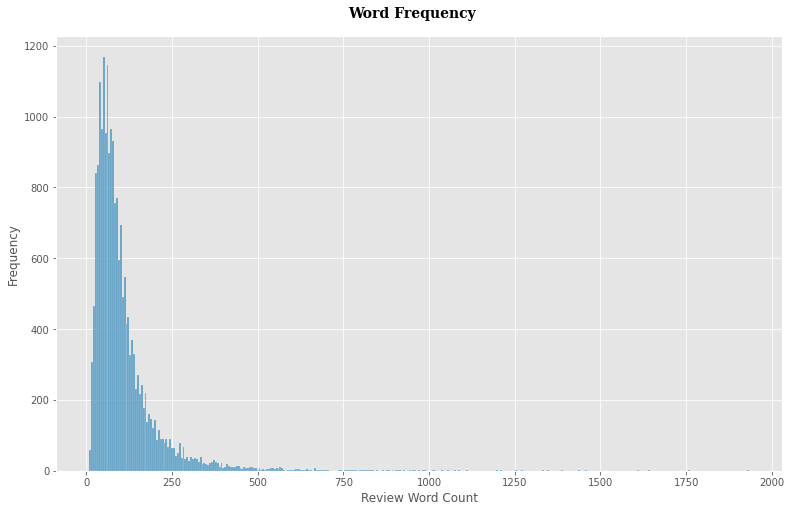

In [261]:
# words per review 
word_count = data.Review.apply(lambda x : len(x.split(" ")))

plt.figure(figsize=(13, 8))
plt.text(950, 1290, 'Word Frequency', fontsize=14, fontweight='bold', 
         horizontalalignment='center', 
         verticalalignment='center',
         fontfamily='serif', color="#000000")
sns.histplot(word_count) 
plt.xlabel("Review Word Count") 
plt.ylabel("Frequency") 
plt.show() 

In [ ]:
print("Average Words:", word_count.mean()) 
print("Skewness:", word_count.skew()) 

Average Words: 106.3750427016739
Skewness: 4.495935249170961


**Take aways:**
1.   73.66 percent of the reviews are rated 4 and 5, shows majority of users felt positively about services. The remaining 26.34 percent are rated 3, 2 and 1 combined. 
2.   Histogram of word count and frequency shows majority of reviews were short with under 100 words.



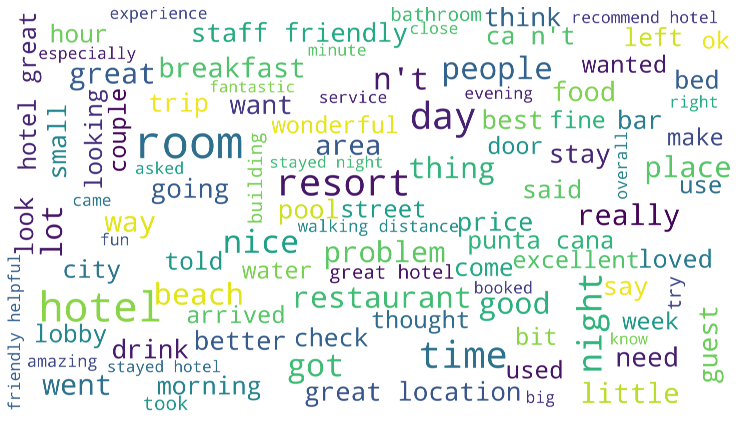

In [ ]:
# plotting word cloud of 100 most commonly used words in reviews. 
word_cloud_img = ''.join(data.Review) 
word_cloud_img = WordCloud(max_font_size=100, max_words=100, width=1600, 
                           height=900, scale=10, 
                           background_color='white').generate(word_cloud_img) 

plt.figure(figsize=(13, 8))
plt.imshow(word_cloud_img, interpolation='bilinear') 
plt.axis('off')
plt.show() 

## Pre-Processing 
1. removing digits and other unwanted characters - this allows the word count to lessen by removing unwanted information. <br>
   For Example: "WE STAYED IN THIS HOTEL FOR 2 DAYS IN ROOM 104 AND IT WAS AWESOME". 
   The information like room number and number of days of stay does not contribute toward the rating.  
2. removing stop words including characters that convey emotion like [!, ?, ...] 
3. use of pretrained **word-embedding model** from tensorflow to generate an embed tensor. Encodes the sentences into 128 features. 










**Stemming/ Lematization** <br>
Stemming usually refers to a process that chops off the ends of words in the hope of achieving goal correctly most of the time and often includes the removal of derivational affixes.<br> 
Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base and dictionary form of a word <br> 
**Why do it ?** <br> 
Reduce number of words by assimilating words by stems (root words).

In [ ]:
stemmer = SnowballStemmer('english') 

stop_words = stopwords.words('english')
print("examples of some of the stopwords\n ")
print(stop_words[:10])  
print(stop_words[11:20]) 

examples of some of the stopwords
 
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
["you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


In [ ]:
# removing digits and stop words
def cleaned_data(review, stem=True): 
  review = re.sub(r'\d+', ' ', review) # removes digits 
  tokens = list()
  for token in review.split(): 
    if (token not in stop_words): 
      if stem: 
        tokens.append(stemmer.stem(token)) 
      else: 
        tokens.append(token)   
  return ' '.join(tokens)   

In [ ]:
# features
X = data.Review.apply(cleaned_data) 
print(X.shape)

# labels
data.Rating = data.iloc[:, -1:].astype('category') 
y = to_categorical(LabelEncoder().fit_transform(data.Rating), 
                   num_classes=5, dtype="int32")  
print(y.shape) 

print(X[0:5]) 

(20491,)
(20491, 5)
0    nice hotel expens park got good deal stay hote...
1    ok noth special charg diamond member hilton de...
2    nice room * experi hotel monaco seattl good ho...
3    unique, great stay, wonder time hotel monaco, ...
4    great stay great stay, went seahawk game aweso...
Name: Review, dtype: object


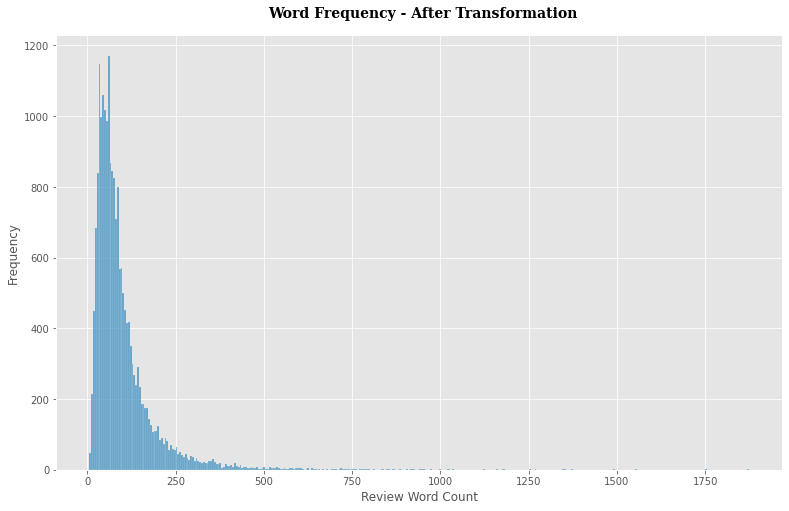

In [260]:
# histogram of cleaned data
word_count_2 = X.apply(lambda x : len(x.split(" ")))


plt.figure(figsize=(13, 8))
plt.text(950, 1290, 'Word Frequency - After Transformation', fontsize=14, fontweight='bold', 
         horizontalalignment='center', 
         verticalalignment='center',
         fontfamily='serif', color="#000000")
sns.histplot(word_count_2) 
plt.xlabel("Review Word Count") 
plt.ylabel("Frequency") 

plt.show() 

In [ ]:
print("Average percentage change in words after data clean up:", 
      round(((word_count - word_count_2) / word_count * 100).mean(), 2))

Average percentage change in words after data clean up: 7.69


In [ ]:
# train and test splits 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.35,
                                                    random_state=True,
                                                    shuffle=True) 

print("Training size", x_train.shape) 
print("Test size", x_test.shape) 

Training size (13319,)
Test size (7172,)


**Word Embedding**


**WHAT DOES NNLM (Neural Network Language Model) DO?**
  1.   Splits the string sentences on spaces. [Does not accept numbers, which is also one of the reasons we removed them from data] 
  2.   Small fraction of the least frequent tokens and embeddings (~2.5%) are replaced by hash buckets. 
         Each hash bucket is initialized using the remaining embedding vectors that hash to the same bucket.
  3.   Word embeddings are combined into sentence embedding using the sqrtn combiner

In [ ]:
embed = hub.load("https://tfhub.dev/google/nnlm-en-dim128/2")  
x_train = embed(x_train) 
x_test = embed(x_test) 

print("training set size - after embedding", x_train.shape)

training set size - after embedding (13319, 128)


**Baseline Model**
<ul>
<li>A sequential network with 2 hidden layers is chosen to serve as benchmark.</li>
<li>Further improvement can be achieved to base model by tuning hyper-parameters.</li>
<li>Comparision of base model to more complex models with LSTM networks and Convolution networks is demonstrated.</li>
<li>Bonus: Comaparison of base model with tensorflow's native estimators.</li>
</ul>

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=256,
    input_shape=(x_train.shape[1], ),
    kernel_regularizer='l2', 
    activation='relu'
  )
)
model.add(
  tf.keras.layers.Dropout(rate=0.5)
)
model.add(
  tf.keras.layers.Dense(
    units=128, 
    kernel_regularizer='l2', 
    activation='relu'
  )
)
model.add(
  tf.keras.layers.Dropout(rate=0.5)
)
model.add(tf.keras.layers.Dense(5, activation='softmax'))
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 5)                 645       
Total params: 66,565
Trainable params: 66,565
Non-trainable params: 0
_________________________________________________________________


**Justification for Algorithm Parameters:** 
1. Optimizer: Adam is the best adaptive optimizers for handling sparse data. Not necessary to tune the learning rate for Adam. 
2. Loss: Categorical Cross Entropy: Ideal for multiclass classification, further improvements can made based on result as we're dealing with sparse matrices for classes. 
3. Metric: Accuracy, Training accuracy needs to the marker for decision on features. Model needs to identify classes accurately.   

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=16,
    validation_split=0.1,
    verbose=1, shuffle=True) 

Epoch 1/10
750/750 [==============================] - 2s 3ms/step - loss: 1.2108 - accuracy: 0.4826 - val_loss: 1.0704 - val_accuracy: 0.5405
Epoch 2/10
750/750 [==============================] - 2s 3ms/step - loss: 1.1080 - accuracy: 0.5232 - val_loss: 1.0500 - val_accuracy: 0.5511
Epoch 3/10
750/750 [==============================] - 2s 2ms/step - loss: 1.0834 - accuracy: 0.5348 - val_loss: 1.0469 - val_accuracy: 0.5390
Epoch 4/10
750/750 [==============================] - 2s 2ms/step - loss: 1.0684 - accuracy: 0.5372 - val_loss: 1.0468 - val_accuracy: 0.5541
Epoch 5/10
750/750 [==============================] - 2s 3ms/step - loss: 1.0658 - accuracy: 0.5385 - val_loss: 1.0328 - val_accuracy: 0.5653
Epoch 6/10
750/750 [==============================] - 2s 3ms/step - loss: 1.0533 - accuracy: 0.5399 - val_loss: 1.0379 - val_accuracy: 0.5503
Epoch 7/10
750/750 [==============================] - 2s 2ms/step - loss: 1.0421 - accuracy: 0.5479 - val_loss: 1.0435 - val_accuracy: 0.5330
Epoch 

In [ ]:
model.evaluate(x_test, y_test) 

225/225 [==============================] - 0s 2ms/step - loss: 1.0538 - accuracy: 0.5266


[1.0537546873092651, 0.5266313552856445]

In [ ]:
print("Average training accuracy", round(np.mean(history.history['accuracy']) * 100, 2)) 
print("Average training loss", round(np.mean(history.history['loss']), 2)) 

Average training accuracy 53.59
Average training loss 1.07


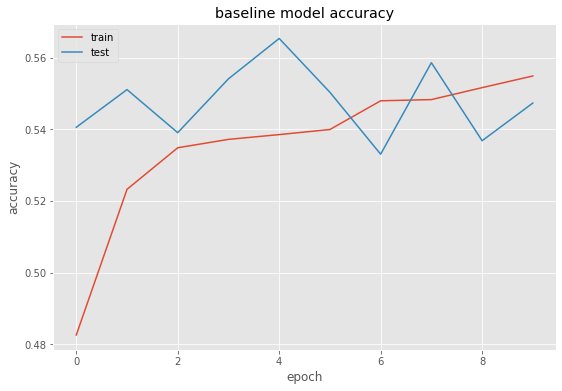

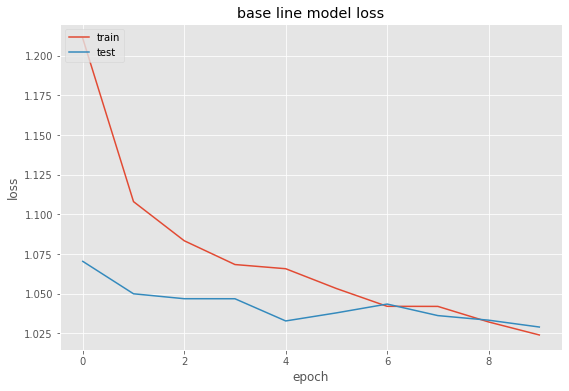

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(9,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('baseline model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(9,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('base line model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Classification Metrics**

In [ ]:
# Metrics on test set 
baseline_prediction = model.predict(x_test) 
baseline_prediction = [np.argmax(i) for i in baseline_prediction] 
actual = [np.argmax(i) for i in y_test] 
count = 0
for i in range(len(x_test)): 
  if(actual[i] == baseline_prediction[i]): 
    count += 1
print("test accuracy" , round((count / len(x_test)) * 100, 2)) 

test accuracy 52.66


In [ ]:
print(classification_report(baseline_prediction, actual)) 

              precision    recall  f1-score   support

           0       0.51      0.62      0.56       431
           1       0.31      0.35      0.33       551
           2       0.07      0.42      0.12       118
           3       0.23      0.42      0.30      1201
           4       0.89      0.57      0.69      4871

    accuracy                           0.53      7172
   macro avg       0.40      0.48      0.40      7172
weighted avg       0.70      0.53      0.58      7172



ValueError: ignored

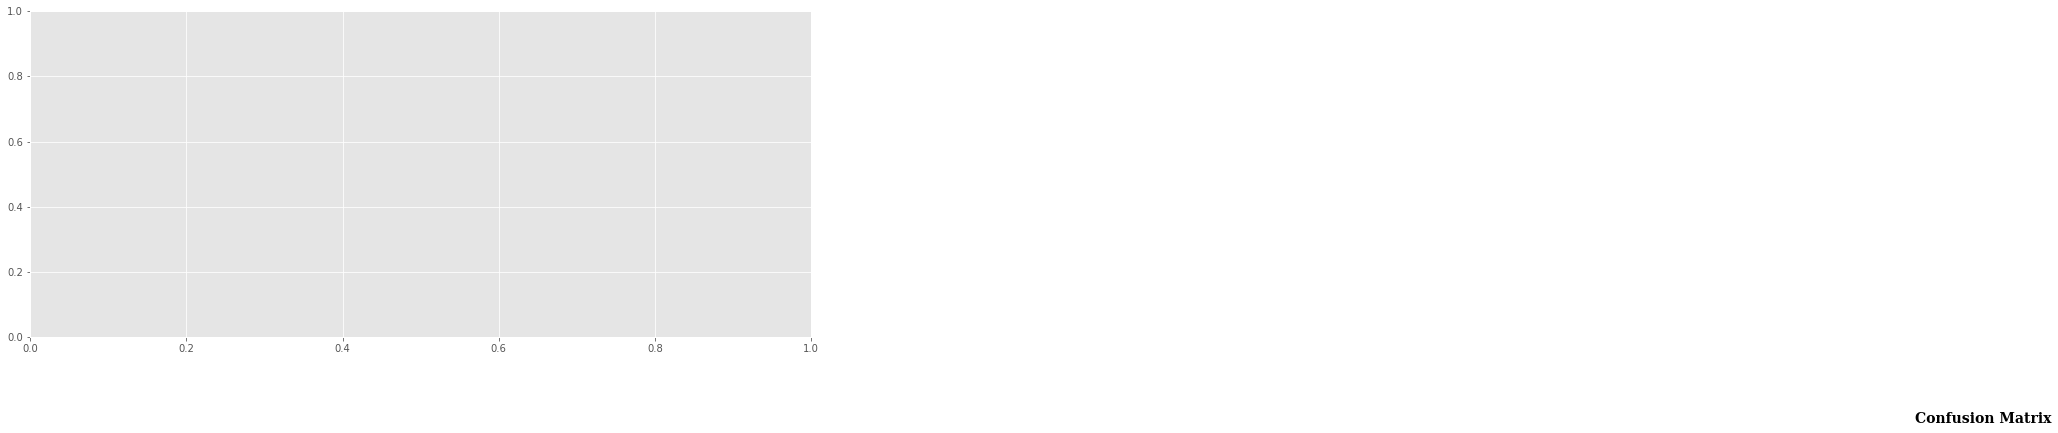

In [237]:
plt.text(2.5, -0.25, 'Confusion Matrix', fontsize=14, fontweight='bold', 
         horizontalalignment='center', 
         verticalalignment='center',
         fontfamily='serif', color="#000000") 
sns.heatmap(confusion_matrix(baseline_prediction, actual), annot=True) 
plt.show() 

**Observations from baseline classifier results:**
1. The prediction for classes 0, 4 (ratings 1 and 5 respectively) are more accurate compared to other 3 classes. It can be infered that in extreme cases the language is more clear but in the rest the language is more subtle/nuanced. 
2. The class imbalance is one of the reasons for poor performance of the model. Sampling techiques can be applied to create a evenly represented training set. 
3. The most missclassified class is for rating 3, it is advisable to club the ratings 2 and 3 as both classes have similar sounding language used. 

**Modification to Base Model** 
1. Model hyperparameters which influence model selection such as the number and width of hidden layers
2. Algorithm hyperparameters which influence the speed and quality of the learning algorithm such as the learning rate for Stochastic Gradient Descent (SGD) OR Adam.  

Manual HP Tuning: 
Proposal 1 
1. Vary the Algorithm parameter by keeping the same model parameters. ie Number of hidden layers and units remain the same  while following changes are made to Algorithmic parameters. 
2. Loss - Sparse categorical crossentropy. 
3. Optimizer RMS PROP with learning rate = 0.001
4. Number of epochs set to 200 

In [ ]:
modified_model = tf.keras.Sequential() 
modified_model.add(tf.keras.layers.Dense(units=256, input_shape=(x_train.shape[1], ), activation='relu'))
modified_model.add(tf.keras.layers.Dropout(rate=0.5)) 
modified_model.add(tf.keras.layers.Dense(units=128, activation='relu'))
modified_model.add(tf.keras.layers.Dropout(rate=0.5)) 
modified_model.add(tf.keras.layers.Dense(5, activation='softmax'))
modified_model.summary() 

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 5)                 645       
Total params: 66,565
Trainable params: 66,565
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modified_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
                       optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                       metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
mod_hist = modified_model.fit(x_train, y_train,
    epochs=200, validation_split=0.2, verbose=1, shuffle=True) 

Epoch 1/200
333/333 [==============================] - 2s 3ms/step - loss: 1.2431 - categorical_accuracy: 0.4679 - val_loss: 1.0819 - val_categorical_accuracy: 0.5353
Epoch 2/200
333/333 [==============================] - 1s 3ms/step - loss: 1.1265 - categorical_accuracy: 0.5149 - val_loss: 1.0702 - val_categorical_accuracy: 0.5402
Epoch 3/200
333/333 [==============================] - 1s 3ms/step - loss: 1.0965 - categorical_accuracy: 0.5198 - val_loss: 1.0401 - val_categorical_accuracy: 0.5432
Epoch 4/200
333/333 [==============================] - 1s 3ms/step - loss: 1.0795 - categorical_accuracy: 0.5355 - val_loss: 1.0350 - val_categorical_accuracy: 0.5548
Epoch 5/200
333/333 [==============================] - 1s 3ms/step - loss: 1.0689 - categorical_accuracy: 0.5388 - val_loss: 1.0388 - val_categorical_accuracy: 0.5503
Epoch 6/200
333/333 [==============================] - 1s 3ms/step - loss: 1.0585 - categorical_accuracy: 0.5426 - val_loss: 1.0457 - val_categorical_accuracy: 0.559

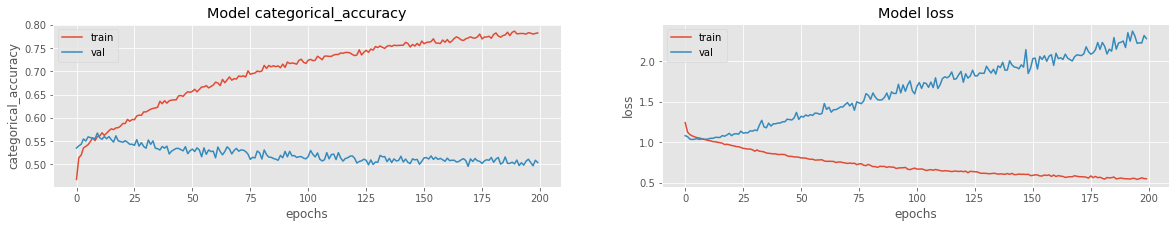

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(['categorical_accuracy', 'loss']):
    ax[i].plot(mod_hist.history[metric])
    ax[i].plot(mod_hist.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

Model is clearly overfitting with no improvement in val_accuracy. Opting for Adam optimizer. 

In [ ]:
modified_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                       metrics=['accuracy'])   

mod_hist2 = modified_model.fit(x_train, y_train,
    epochs=200, validation_split=0.2, verbose=1, shuffle=True) 

Epoch 1/200
333/333 [==============================] - 1s 3ms/step - loss: 0.5539 - accuracy: 0.7810 - val_loss: 2.1305 - val_accuracy: 0.5053
Epoch 2/200
333/333 [==============================] - 1s 3ms/step - loss: 0.5741 - accuracy: 0.7714 - val_loss: 2.0482 - val_accuracy: 0.5071
Epoch 3/200
333/333 [==============================] - 1s 3ms/step - loss: 0.5679 - accuracy: 0.7693 - val_loss: 1.9874 - val_accuracy: 0.4951
Epoch 4/200
333/333 [==============================] - 1s 3ms/step - loss: 0.5507 - accuracy: 0.7802 - val_loss: 2.0123 - val_accuracy: 0.5083
Epoch 5/200
333/333 [==============================] - 1s 3ms/step - loss: 0.5679 - accuracy: 0.7722 - val_loss: 2.0518 - val_accuracy: 0.5079
Epoch 6/200
333/333 [==============================] - 1s 3ms/step - loss: 0.5538 - accuracy: 0.7767 - val_loss: 2.2600 - val_accuracy: 0.4996
Epoch 7/200
333/333 [==============================] - 1s 3ms/step - loss: 0.5660 - accuracy: 0.7733 - val_loss: 1.9922 - val_accuracy: 0.4929

In [ ]:
modified_model.evaluate(x_test, y_test) 

225/225 [==============================] - 0s 2ms/step - loss: 3.9875 - accuracy: 0.5024


[3.9874603748321533, 0.5023703575134277]

**Tuning model through Random Search Iterator**

In [ ]:
def model_builder(params):
  model = tf.keras.Sequential() 
  model.add(tf.keras.layers.Flatten(input_shape=(x_train.shape[1],)))
  # chosing hidden layers b/w 2 and 20 
  for i in range(params.Int('num_layers', 2, 10)): 
    model.add(tf.keras.layers.Dense(units=params.Int('units_' + str(i), 
              min_value=32, max_value=512, step=32), 
              activation=params.Choice('actication', values=['relu', 'tanh'])))  
    model.add(tf.keras.layers.Dense(5, activation='softmax')) 
    hp_learning_rate = params.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), 
        loss='categorical_crossentropy', metrics=['accuracy'])
    return model 

In [ ]:
path = "/content/drive/MyDrive/DL Assignment 1 - Group-016"

In [ ]:
rs_tuner = kt.RandomSearch(model_builder, objective='accuracy', max_trials=5)
rs_tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
actication (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
rs_tuner.search(x_train,y_train) 

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
rs_tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='accuracy', direction='max')
Trial summary
Hyperparameters:
num_layers: 5
units_0: 256
actication: relu
learning_rate: 0.01
Score: 0.5151287913322449
Trial summary
Hyperparameters:
num_layers: 9
units_0: 320
actication: relu
learning_rate: 0.01
Score: 0.5139274597167969
Trial summary
Hyperparameters:
num_layers: 5
units_0: 128
actication: relu
learning_rate: 0.01
Score: 0.5132517218589783
Trial summary
Hyperparameters:
num_layers: 9
units_0: 160
actication: tanh
learning_rate: 0.001
Score: 0.5049928426742554
Trial summary
Hyperparameters:
num_layers: 5
units_0: 416
actication: tanh
learning_rate: 0.0001
Score: 0.4570162892341614


In [ ]:
rs_recommended_model = tf.keras.Sequential() 
rs_recommended_model.add(tf.keras.layers.Dense(352, 
                                               input_shape=(x_train.shape[1], ), 
                                               activation='relu')) # layer 1
rs_recommended_model.add(tf.keras.layers.Dense(234, activation='relu')) # layer 2
rs_recommended_model.add(tf.keras.layers.Dropout(rate=0.5)) # layer 3 
rs_recommended_model.add(tf.keras.layers.Dense(156, activation='relu')) # layer 4
rs_recommended_model.add(tf.keras.layers.Dense(104, activation='relu')) # layer 5 
rs_recommended_model.add(tf.keras.layers.Dropout(rate=0.5)) # layer 6 
rs_recommended_model.add(tf.keras.layers.Dense(68, activation='relu')) # layer 7 
rs_recommended_model.add(tf.keras.layers.Dense(5, activation='softmax')) # layer 8
rs_recommended_model.summary() 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 352)               45408     
_________________________________________________________________
dense_3 (Dense)              (None, 234)               82602     
_________________________________________________________________
dropout (Dropout)            (None, 234)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 156)               36660     
_________________________________________________________________
dense_5 (Dense)              (None, 104)               16328     
_________________________________________________________________
dropout_1 (Dropout)          (None, 104)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 68)               

In [ ]:
rs_recommended_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
                       optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                       metrics=[tf.keras.metrics.CategoricalAccuracy()]) 
rs_hist = rs_recommended_model.fit(x_train, y_train,
    epochs=100, validation_split=0.2, verbose=1, shuffle=True) 

Epoch 1/100
333/333 [==============================] - 2s 5ms/step - loss: 1.2248 - categorical_accuracy: 0.4648 - val_loss: 1.1537 - val_categorical_accuracy: 0.4981
Epoch 2/100
333/333 [==============================] - 1s 4ms/step - loss: 1.1195 - categorical_accuracy: 0.5140 - val_loss: 1.0979 - val_categorical_accuracy: 0.5338
Epoch 3/100
333/333 [==============================] - 1s 4ms/step - loss: 1.0921 - categorical_accuracy: 0.5321 - val_loss: 1.0406 - val_categorical_accuracy: 0.5432
Epoch 4/100
333/333 [==============================] - 1s 4ms/step - loss: 1.0707 - categorical_accuracy: 0.5399 - val_loss: 1.0502 - val_categorical_accuracy: 0.5495
Epoch 5/100
333/333 [==============================] - 1s 4ms/step - loss: 1.0437 - categorical_accuracy: 0.5533 - val_loss: 1.0397 - val_categorical_accuracy: 0.5541
Epoch 6/100
333/333 [==============================] - 1s 4ms/step - loss: 1.0251 - categorical_accuracy: 0.5537 - val_loss: 1.0461 - val_categorical_accuracy: 0.556

In [ ]:
rs_recommended_model.evaluate(x_test, y_test) 

225/225 [==============================] - 1s 2ms/step - loss: 13.7009 - categorical_accuracy: 0.4731


[13.700857162475586, 0.4730897843837738]

**Observation:** 
1. Model clearly overfits as expected from the increase in width and height of network. 
2. Test set accuracy is still at half way mark, model is no better than a coin flip. 
3. Alternatively approach to test LSTM layers in network architecture could be beneficial. 

**LSTM MODEL**  w/ Glove text encoding

In [ ]:
max_features = 20000  # Only consider the top 20k words
maxlen = 128  # Only consider the first 200 words of each movie review

In [ ]:
# tokenizing the text - features 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size) 

Vocabulary Size : 45022


In [ ]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

In [ ]:
GLOVE_EMB_PATH = 'glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 50

embeddings_index = {}

f = open(GLOVE_EMB_PATH)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

In [ ]:
print('Found %s word vectors.' %len(embeddings_index)) 

Found 400000 word vectors.


In [ ]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector 

In [ ]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=maxlen,
                                          trainable=False) 

**LSTM MODEL:** <br>
Number of units calculation: <br> <center>Training Size / Scaling factor * (N(inputs) + N(outputs))  <br> 
14343 / (2 * (128 + 5)) <br>
Approx 54 units.

In [ ]:
sequence_input = tf.keras.Input(shape=(maxlen,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = tf.keras.layers.SpatialDropout1D(0.2)(embedding_sequences)
x = tf.keras.layers.Conv1D(64, 5, activation='relu')(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)
model = tf.keras.Model(sequence_input, outputs) 

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1) 

In [ ]:
train, test, train_labels, test_labels = train_test_split(X, y, test_size=0.2, 
                                                          random_state=42) 

print(train.shape) 

(16392,)


In [ ]:
train = tf.keras.preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(train), maxlen=maxlen) 

test = tf.keras.preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(test), maxlen=maxlen)  

print(train.shape, test.shape)

(16392, 128) (4099, 128)


In [213]:
history = model.fit(train, train_labels, batch_size=516, epochs=20, 
                    validation_split=0.2, shuffle=True, 
                    callbacks=[ReduceLROnPlateau])    

Epoch 1/15
26/26 [==============================] - 26s 984ms/step - loss: 0.3056 - accuracy: 0.8756 - val_loss: 1.6227 - val_accuracy: 0.5590
Epoch 2/15
26/26 [==============================] - 26s 1s/step - loss: 0.3091 - accuracy: 0.8774 - val_loss: 1.5829 - val_accuracy: 0.5602
Epoch 3/15
26/26 [==============================] - 26s 1s/step - loss: 0.3058 - accuracy: 0.8803 - val_loss: 1.5909 - val_accuracy: 0.5624
Epoch 4/15
26/26 [==============================] - 27s 1s/step - loss: 0.2904 - accuracy: 0.8848 - val_loss: 1.6553 - val_accuracy: 0.5639
Epoch 5/15
26/26 [==============================] - 26s 1s/step - loss: 0.2835 - accuracy: 0.8877 - val_loss: 1.7218 - val_accuracy: 0.5743
Epoch 6/15
26/26 [==============================] - 26s 993ms/step - loss: 0.2859 - accuracy: 0.8878 - val_loss: 1.6420 - val_accuracy: 0.5642
Epoch 7/15
26/26 [==============================] - 26s 989ms/step - loss: 0.2744 - accuracy: 0.8898 - val_loss: 1.6635 - val_accuracy: 0.5621
Epoch 8/15


In [214]:
model.evaluate(test, test_labels) 

129/129 [==============================] - 8s 60ms/step - loss: 1.7727 - accuracy: 0.5543


[1.7727024555206299, 0.5542815327644348]

In [215]:
print("training accuracy :", round(np.max(history.history['accuracy']) * 100, 2)) 
print("training loss :", round(np.max(history.history['loss']), 2)) 

training accuracy : 90.09
training loss : 0.31


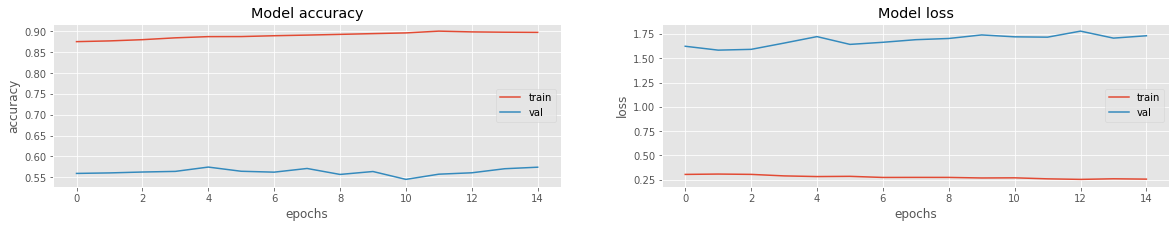

In [216]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [217]:
# classification metrics 
prediction = model.predict(test) 
prediction = [np.argmax(i) for i in prediction] 
actual = [np.argmax(i) for i in test_labels] 

print(classification_report(prediction, actual))  

              precision    recall  f1-score   support

           0       0.54      0.64      0.58       246
           1       0.38      0.34      0.36       368
           2       0.25      0.34      0.29       321
           3       0.43      0.46      0.44      1158
           4       0.75      0.67      0.71      2006

    accuracy                           0.55      4099
   macro avg       0.47      0.49      0.48      4099
weighted avg       0.57      0.55      0.56      4099



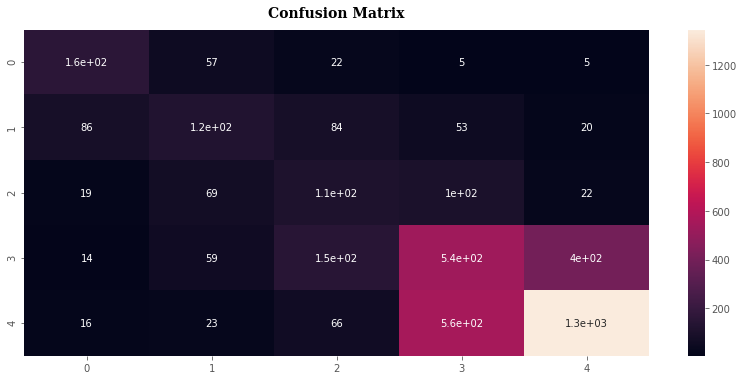

In [319]:
plt.text(2.5, -0.25, 'Confusion Matrix', fontsize=14, fontweight='bold', 
         horizontalalignment='center', 
         verticalalignment='center',
         fontfamily='serif', color="#000000") 
sns.heatmap(confusion_matrix(prediction, actual), annot=True) 
plt.show()  

**Observations:**
1. LSTM layers certainly improved the training accuracy significantly but not as big of leap in test accuracy.  
2. Model can be improved by further tuning of hyper-parameters but the idea is droped due to computational difficulties, initial training for current model took over 3 hours in early iterations. A compromise parameters are chosen to hasten training sessions. 
3. The key drawbacks that are common across all the models that have been tried, 
  *   Class imbalance
  *   Language similarity and overlap for classes 2 and 3 
4. A better classification result can be achieved by merging ratings 2 and 3. Better yet combining ratings 4 and 5 as positive, rest termed as negative class. 



**Tensorflow Native Estimators**

In [305]:
# processing the data 
def cleaned_data(review): 
  review = re.sub(r'\d+', ' ', review) # removes digits 
  review = review.split() 
  review = ' '.join([word for word in review 
                    if not word in stop_words]) # removes stopwords
  
  return review 


# features
data.Review = data.Review.apply(cleaned_data) 
print(data.Review.shape)
print(data.Review.loc[10:15]) 

# labels - sparse categorical 
encoding = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
data.Rating.replace(encoding, inplace=True) 
print(data.Rating.head()) 

(20491,)
10    poor value stayed monaco seattle july, nice ho...
11    nice value seattle stayed nights late . looked...
12    nice hotel good location hotel kimpton design ...
13    nice hotel nice staff hotel lovely staff quite...
14    great hotel night quick business trip, loved l...
15    horrible customer service hotel stay february ...
Name: Review, dtype: object
0    3
1    1
2    2
3    4
4    4
Name: Rating, dtype: int64


In [306]:
# spliting train and test 
data_copy = data.copy()
train = data_copy.sample(frac=0.7, random_state=42)
test = data_copy.drop(train.index)

print("Training set: ", train.shape, "\nTestset: ",test.shape) 

Training set:  (14344, 2) 
Testset:  (6147, 2)


In [311]:
# input functions for model 
train_input_function = tf.compat.v1.estimator.inputs.pandas_input_fn(
    train, train.Rating, num_epochs=None, shuffle=True) 

# train prediction input 
predict_train_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    train, train.Rating, shuffle=False)

# test prediction input 
prediction_test_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    test, test.Rating, shuffle=False)

In [312]:
# feature columns 
embedded_text_feature_column = hub.text_embedding_column(key="Review", 
    module_spec="https://tfhub.dev/google/nnlm-en-dim128/1") 

In [313]:
estimator = tf.compat.v1.estimator.DNNClassifier(
    hidden_units=[1024, 512, 256], feature_columns=[embedded_text_feature_column],
    n_classes=5,
    optimizer=tf.compat.v1.train.AdagradOptimizer(learning_rate=0.003)) 

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp7iwmn4us', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp7iwmn4us', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [314]:
estimator.train(input_fn=train_input_function, steps=1000);  

Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp7iwmn4us/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp7iwmn4us/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:loss = 204.16003, step = 0


INFO:tensorflow:loss = 204.16003, step = 0


INFO:tensorflow:global_step/sec: 93.531


INFO:tensorflow:global_step/sec: 93.531


INFO:tensorflow:loss = 116.4229, step = 100 (1.076 sec)


INFO:tensorflow:loss = 116.4229, step = 100 (1.076 sec)


INFO:tensorflow:global_step/sec: 97.156


INFO:tensorflow:global_step/sec: 97.156


INFO:tensorflow:loss = 142.40218, step = 200 (1.029 sec)


INFO:tensorflow:loss = 142.40218, step = 200 (1.029 sec)


INFO:tensorflow:global_step/sec: 99.6788


INFO:tensorflow:global_step/sec: 99.6788


INFO:tensorflow:loss = 145.53763, step = 300 (1.002 sec)


INFO:tensorflow:loss = 145.53763, step = 300 (1.002 sec)


INFO:tensorflow:global_step/sec: 101.693


INFO:tensorflow:global_step/sec: 101.693


INFO:tensorflow:loss = 125.12633, step = 400 (0.983 sec)


INFO:tensorflow:loss = 125.12633, step = 400 (0.983 sec)


INFO:tensorflow:global_step/sec: 102.779


INFO:tensorflow:global_step/sec: 102.779


INFO:tensorflow:loss = 123.552, step = 500 (0.976 sec)


INFO:tensorflow:loss = 123.552, step = 500 (0.976 sec)


INFO:tensorflow:global_step/sec: 101.185


INFO:tensorflow:global_step/sec: 101.185


INFO:tensorflow:loss = 120.82508, step = 600 (0.994 sec)


INFO:tensorflow:loss = 120.82508, step = 600 (0.994 sec)


INFO:tensorflow:global_step/sec: 101.435


INFO:tensorflow:global_step/sec: 101.435


INFO:tensorflow:loss = 119.20912, step = 700 (0.979 sec)


INFO:tensorflow:loss = 119.20912, step = 700 (0.979 sec)


INFO:tensorflow:global_step/sec: 101.667


INFO:tensorflow:global_step/sec: 101.667


INFO:tensorflow:loss = 119.00133, step = 800 (0.983 sec)


INFO:tensorflow:loss = 119.00133, step = 800 (0.983 sec)


INFO:tensorflow:global_step/sec: 102.837


INFO:tensorflow:global_step/sec: 102.837


INFO:tensorflow:loss = 116.14978, step = 900 (0.969 sec)


INFO:tensorflow:loss = 116.14978, step = 900 (0.969 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1000...


INFO:tensorflow:Saving checkpoints for 1000 into /tmp/tmp7iwmn4us/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1000 into /tmp/tmp7iwmn4us/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1000...


INFO:tensorflow:Loss for final step: 115.20302.


INFO:tensorflow:Loss for final step: 115.20302.


In [315]:
# evaluation 
train_eval_result = estimator.evaluate(input_fn=predict_train_fn)
test_eval_result = estimator.evaluate(input_fn=prediction_test_fn)

print("Training set accuracy: {accuracy}".format(**train_eval_result))
print("Test set accuracy: {accuracy}".format(**test_eval_result))

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-07-14T19:39:46


INFO:tensorflow:Starting evaluation at 2021-07-14T19:39:46


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmp7iwmn4us/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /tmp/tmp7iwmn4us/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 1.64024s


INFO:tensorflow:Inference Time : 1.64024s


INFO:tensorflow:Finished evaluation at 2021-07-14-19:39:47


INFO:tensorflow:Finished evaluation at 2021-07-14-19:39:47


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.60506135, average_loss = 0.903681, global_step = 1000, loss = 114.71151


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.60506135, average_loss = 0.903681, global_step = 1000, loss = 114.71151


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmp7iwmn4us/model.ckpt-1000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmp7iwmn4us/model.ckpt-1000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-07-14T19:39:48


INFO:tensorflow:Starting evaluation at 2021-07-14T19:39:48


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmp7iwmn4us/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /tmp/tmp7iwmn4us/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 1.15673s


INFO:tensorflow:Inference Time : 1.15673s


INFO:tensorflow:Finished evaluation at 2021-07-14-19:39:49


INFO:tensorflow:Finished evaluation at 2021-07-14-19:39:49


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.57019687, average_loss = 0.9600561, global_step = 1000, loss = 120.43806


INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.57019687, average_loss = 0.9600561, global_step = 1000, loss = 120.43806


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmp7iwmn4us/model.ckpt-1000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmp7iwmn4us/model.ckpt-1000


Training set accuracy: 0.6050613522529602
Test set accuracy: 0.5701968669891357


In [316]:
def get_predictions(estimator, input_fn):
  return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

LABELS = ["1", "2", "3", "4", "5"]

# Create a confusion matrix on training data.
cm = tf.math.confusion_matrix(train["Rating"], 
                              get_predictions(estimator, predict_train_fn)) 

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmp7iwmn4us/model.ckpt-1000


INFO:tensorflow:Restoring parameters from /tmp/tmp7iwmn4us/model.ckpt-1000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


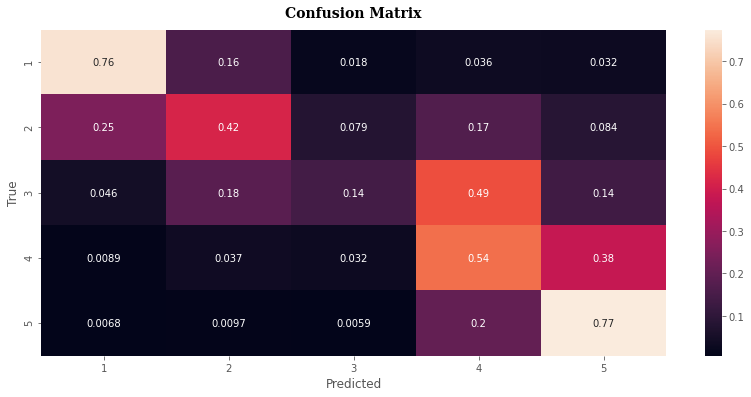

In [320]:
# Normalize the confusion matrix so that each row sums to 1.
cm = tf.cast(cm, dtype=tf.float32)
cm = cm / tf.math.reduce_sum(cm, axis=1)[:, np.newaxis]

plt.text(2.5, -0.25, 'Confusion Matrix', fontsize=14, fontweight='bold', 
         horizontalalignment='center', 
         verticalalignment='center',
         fontfamily='serif', color="#000000") 
sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show() 

### Evaluation